In [24]:
# packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from mlxtend.plotting import ecdf # empirical CDF plot

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [25]:
# read file
df = pd.read_csv('California_Fire_Incidents.csv')
df.head(10)

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,NaN,2013,True,/incidents/2013/5/30/powerhouse-fire/,NaN,NaN,Los Angeles,...,"Powerhouse Fire, May 2013, June 2013, Angeles ...",2013-05-30T15:28:00Z,Finalized,NaN,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08T18:30:00Z,NaN
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/7/15/mountain-fire/,NaN,NaN,Riverside,...,"Mountain Fire, July 2013, Highway 243, Highway...",2013-07-15T13:43:00Z,Finalized,NaN,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30T18:00:00Z,NaN
3,27440.0,False,Tahoe National Forest,NaN,2013,False,/incidents/2013/8/10/american-fire/,NaN,NaN,Placer,...,"American Fire, August 2013, Deadwood Ridge, Fo...",2013-08-10T16:30:00Z,Finalized,NaN,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30T08:00:00Z,NaN
4,24251.0,False,Ventura County Fire/CAL FIRE,NaN,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,NaN,Ventura,...,"Springs Fire, May 2013, Highway 101, Camarillo...",2013-05-02T07:01:00Z,Finalized,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11T06:30:00Z,11.0
5,22992.0,False,Sierra National Forest,NaN,2013,False,/incidents/2013/7/22/aspen-fire/,NaN,NaN,Fresno,...,"217 Aspen Fire, July 2013, Big Creek, Fresno ...",2013-07-22T22:15:00Z,Finalized,NaN,NaN,NaN,NaN,bee8c339-4f26-4b78-a5b4-a8a0ebdb8786,2013-09-24T20:15:00Z,NaN
6,20292.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/8/7/silver-fire/,Firefighters closed the containment lines toda...,Hwy 243 remains closed between Twin Pines Road...,Riverside,...,"Silver Fire, August 2013, Popet Flats Road, Hi...",2013-08-07T14:05:00Z,Finalized,8.0,40.0,NaN,NaN,c400203b-a7fd-4bd8-803a-f3c74bc32a2b,2013-08-12T18:00:00Z,20.0
7,14754.0,False,Klamath National Forest,NaN,2013,False,/incidents/2013/7/31/salmon-river-complex/,NaN,NaN,Siskiyou,...,"210 Salmon River Complex, August 2013, July 20...",2013-07-31T22:00:00Z,Finalized,NaN,NaN,NaN,NaN,ba76c009-09c9-497c-b923-1ac8cf05c20d,2013-08-31T06:45:00Z,NaN
8,12503.0,False,Six Rivers National Forest,NaN,2013,False,/incidents/2013/8/10/corral-complex/,NaN,NaN,Humboldt,...,"Corral Complex, August 2013, Tish Tang Ridge, ...",2013-08-10T11:40:00Z,Finalized,NaN,NaN,NaN,NaN,f3dcbca8-f8ed-46d0-8f6e-9c7fc2fb03e6,2013-08-12T12:00:00Z,NaN
9,11429.0,False,CAL FIRE Tehama-Glenn Unit,NaN,2013,True,/incidents/2013/8/23/deer-fire/,Fire suppression repair will continue througho...,NaN,Tehama,...,"Deer Fire, August 2013, Tehama County, Deer Cr...",2013-08-23T14:15:00Z,Finalized,NaN,NaN,NaN,NaN,956dbcf6-db40-4b61-b235-4ede14738f1e,2013-08-29T16:45:00Z,8.0


In [26]:
# show all column names
df.columns

Index(['AcresBurned', 'Active', 'AdminUnit', 'AirTankers', 'ArchiveYear',
       'CalFireIncident', 'CanonicalUrl', 'ConditionStatement',
       'ControlStatement', 'Counties', 'CountyIds', 'CrewsInvolved', 'Dozers',
       'Engines', 'Extinguished', 'Fatalities', 'Featured', 'Final',
       'FuelType', 'Helicopters', 'Injuries', 'Latitude', 'Location',
       'Longitude', 'MajorIncident', 'Name', 'PercentContained',
       'PersonnelInvolved', 'Public', 'SearchDescription', 'SearchKeywords',
       'Started', 'Status', 'StructuresDamaged', 'StructuresDestroyed',
       'StructuresEvacuated', 'StructuresThreatened', 'UniqueId', 'Updated',
       'WaterTenders'],
      dtype='object')

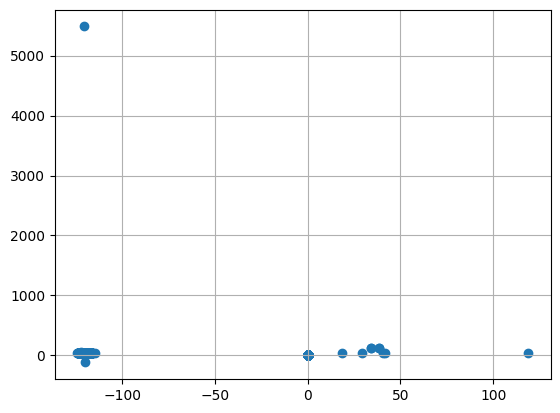

In [27]:
# check coordinates; there are quite a few unrealistic ones
plt.scatter(df.Longitude, df.Latitude)
plt.grid()
plt.show()

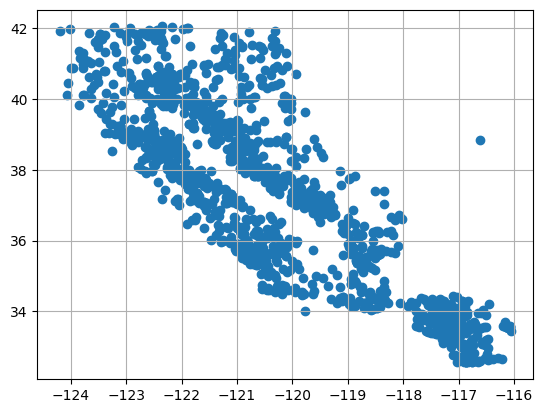

In [28]:
# remove those rows having unrealistic coordinates
df_select = df[df.Longitude<-115]
df_select = df_select[(df_select.Latitude<44) & (df_select.Latitude > 30)]
plt.scatter(df_select.Longitude, df_select.Latitude)
plt.grid()
plt.show()

Outlier Lon/Lat: 113   -116.61
Name: Longitude, dtype: float64 113    38.838
Name: Latitude, dtype: float64


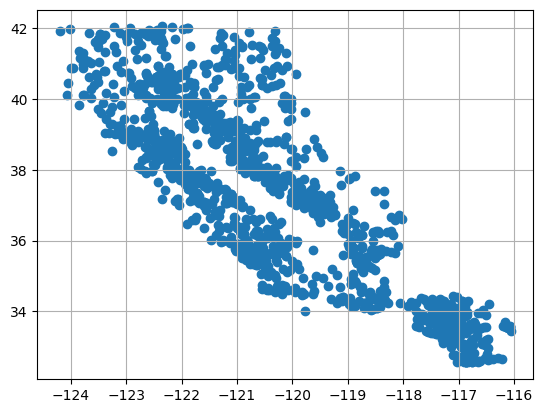

In [29]:
outlier = df_select[df_select.CanonicalUrl=='/incidents/2013/8/6/tram-fire/']
print('Outlier Lon/Lat:', outlier.Longitude, outlier.Latitude)
df_select = df_select[df_select.CanonicalUrl!='/incidents/2013/8/6/tram-fire/']
plt.scatter(df_select.Longitude, df_select.Latitude)
plt.grid()
plt.show()

In [30]:
# interactive map
zoom_factor = 5 # inital map size
radius_scaling = 50 # scaling of bubbles

my_map_1 = folium.Map(location=[36,-120], zoom_start=zoom_factor)

for i in range(0,df_select.shape[0]):
   folium.Circle(
      location=[df_select.iloc[i]['Latitude'], df_select.iloc[i]['Longitude']],
      radius=np.sqrt(df_select.iloc[i]['AcresBurned'])*radius_scaling,
      color='red',
      popup='CanonicalUrl:' + df_select.iloc[i]['CanonicalUrl'] + ' - Year:' + str(int(df_select.iloc[i]['ArchiveYear'])) + ' - Acres Burned:' 
      + str(df_select.iloc[i]['AcresBurned']),
      fill=True,
      fill_color='red'
   ).add_to(my_map_1)

my_map_1 # display

In [31]:
# use heatmap
my_map_2 = folium.Map(location=[36,-120], zoom_start=zoom_factor)
HeatMap(data=df_select[['Latitude', 'Longitude']], radius=10).add_to(my_map_2)

my_map_2 # display

In [32]:
# select year 2018
df_select_2018 = df_select[df_select.ArchiveYear==2018]

In [33]:
# interactive map
zoom_factor = 5 # inital map size
radius_scaling = 50 # scaling of bubbles

my_map_2 = folium.Map(location=[36,-120], zoom_start=zoom_factor)

for i in range(0,df_select_2018.shape[0]):
   folium.Circle(
      location=[df_select_2018.iloc[i]['Latitude'], df_select_2018.iloc[i]['Longitude']],
      radius=np.sqrt(df_select_2018.iloc[i]['AcresBurned'])*radius_scaling,
      color='red',
      popup='CanonicalUrl:' + df_select_2018.iloc[i]['CanonicalUrl'] + ' - Year:' + str(int(df_select_2018.iloc[i]['ArchiveYear'])) + ' - Acres Burned:' 
      + str(df_select_2018.iloc[i]['AcresBurned']),
      fill=True,
      fill_color='red'
   ).add_to(my_map_2)

my_map_2 # display

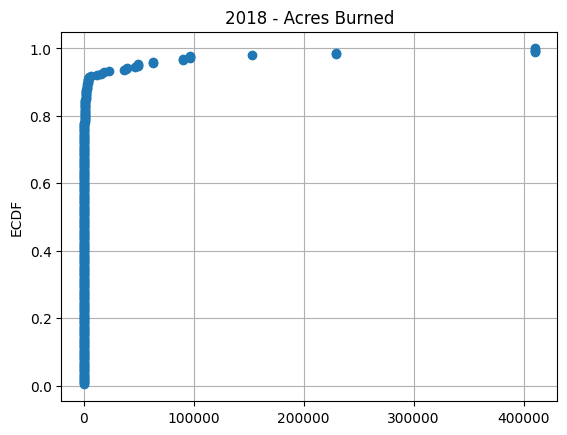

In [34]:
ecdf(df_select_2018.AcresBurned)
plt.grid()
plt.title('2018 - Acres Burned')
plt.show()

/home/hardik/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


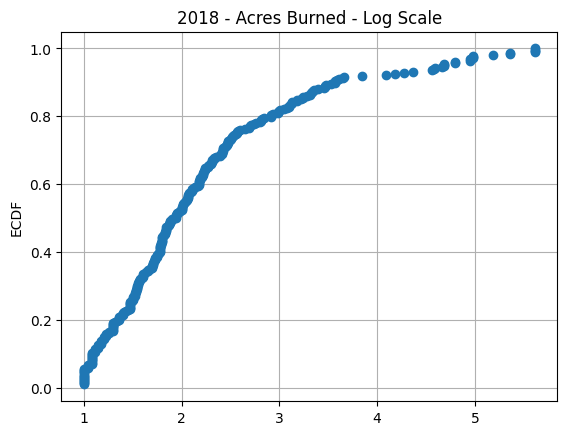

In [35]:
ecdf(np.log10(df_select_2018.AcresBurned))
plt.grid()
plt.title('2018 - Acres Burned - Log Scale')
plt.show()